1. Install Required Libraries

In [43]:
%pip install numpy pandas scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


2. Load Required Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


3. Load the Dataset

In [45]:

file_path = r"C:\Users\User\Desktop\Data analytics assignments\Clustering SEE\med_events.csv"

df = pd.read_csv(file_path)

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PATIENT_ID  1080 non-null   int64 
 1   DATE        1080 non-null   object
 2   PERDAY      1080 non-null   int64 
 3   CATEGORY    1080 non-null   object
 4   DURATION    1080 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 42.3+ KB
None


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1,04/26/2033,4,medA,50
1,1,07/04/2033,4,medB,30
2,1,08/03/2033,4,medB,30
3,1,08/17/2033,4,medB,30
4,1,10/13/2033,4,medB,30


4. Preprocess the Dataset

In [46]:
# Rename columns for clarity (based on the R code structure)
df.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

# Convert `eksd` (prescription date) to datetime
df["eksd"] = pd.to_datetime(df["eksd"])

# Sort by patient ID (`pnr`) and prescription date (`eksd`)
df = df.sort_values(by=["pnr", "eksd"])

# Compute time interval (days) between consecutive prescriptions
df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
df["event_interval"] = (df["eksd"] - df["prev_eksd"]).dt.days

# Drop NaN (first prescription per patient has no previous date)
df = df.dropna().reset_index(drop=True)

# Display cleaned data
df.head()


,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval
0,1,2033-07-04,4,medB,30,2033-04-26,69.0
1,1,2033-08-03,4,medB,30,2033-07-04,30.0
2,1,2033-08-17,4,medB,30,2033-08-03,14.0
3,1,2033-10-13,4,medB,30,2033-08-17,57.0
4,1,2033-10-16,4,medB,30,2033-10-13,3.0


5. Fix Flaws in the R Code

Flaw: Using Only One Random Interval

The R script randomly selects only one interval per patient using sample(nrow(x),1).

Problem: This approach wastes data and reduces accuracy.
Fix: Use all available intervals per patient instead of just one.

6. Flaw: Removing the Top 20% of ECDF

 Fix: Use IQR-based outlier removal instead of a fixed 20% ECDF cutoff.

In [47]:
# Calculate IQR (Interquartile Range) for event intervals
Q1 = df["event_interval"].quantile(0.25)
Q3 = df["event_interval"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme outliers dynamically
df_filtered = df[(df["event_interval"] >= lower_bound) & (df["event_interval"] <= upper_bound)]

# Display filtered dataset
df_filtered.head()


,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval
0,1,2033-07-04,4,medB,30,2033-04-26,69.0
1,1,2033-08-03,4,medB,30,2033-07-04,30.0
2,1,2033-08-17,4,medB,30,2033-08-03,14.0
3,1,2033-10-13,4,medB,30,2033-08-17,57.0
4,1,2033-10-16,4,medB,30,2033-10-13,3.0


7. Apply SEE (K-Means)


In [48]:
# Create a copy of df_filtered before modifying it
df_filtered = df_filtered.copy()

# Standardize the event intervals for clustering
scaler = StandardScaler()
df_filtered.loc[:, "event_interval_scaled"] = scaler.fit_transform(df_filtered[["event_interval"]])

# Apply K-Means Clustering (SEE Method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_filtered.loc[:, "SEE_Cluster"] = kmeans.fit_predict(df_filtered[["event_interval_scaled"]])

# Display results
df_filtered.head()


,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval,event_interval_scaled,SEE_Cluster
0,1,2033-07-04,4,medB,30,2033-04-26,69.0,0.328360,2
1,1,2033-08-03,4,medB,30,2033-07-04,30.0,-0.647197,0
2,1,2033-08-17,4,medB,30,2033-08-03,14.0,-1.047426,0
3,1,2033-10-13,4,medB,30,2033-08-17,57.0,0.028189,2
4,1,2033-10-16,4,medB,30,2033-10-13,3.0,-1.322583,0


8. Visualize Clustering Results & Box Plot

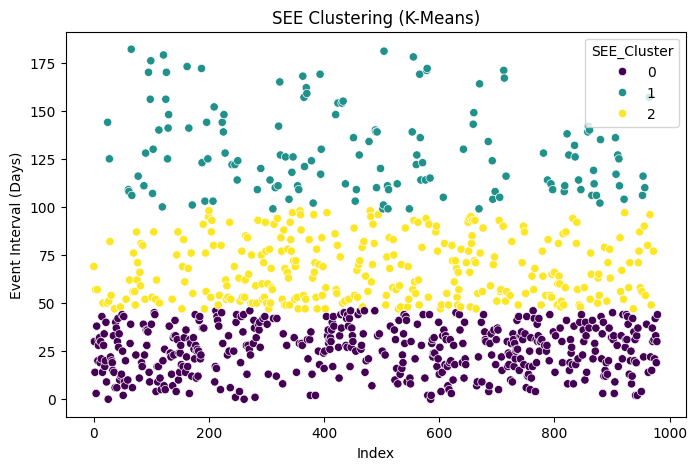

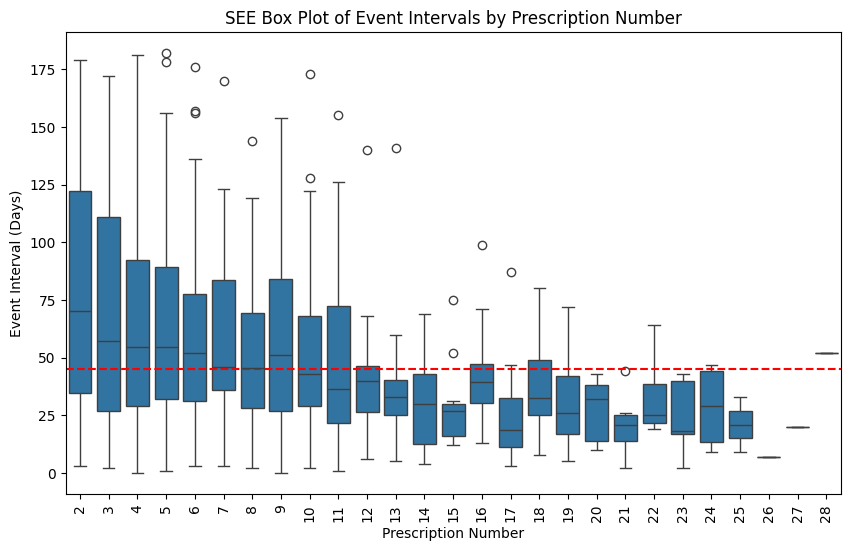

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# 1️⃣ SEE Clustering (K-Means)
sns.scatterplot(x=df_filtered.index, y=df_filtered["event_interval"], hue=df_filtered["SEE_Cluster"], palette="viridis")
plt.xlabel("Index")
plt.ylabel("Event Interval (Days)")
plt.title("SEE Clustering (K-Means)")

plt.show()

# 2️⃣ SEE Box Plot for Event Intervals by Prescription Number
plt.figure(figsize=(10, 6))

# Ensure p_number represents prescription order
df_filtered["p_number"] = df_filtered.groupby("pnr").cumcount() + 2  # Starts from 2 like the R script

sns.boxplot(x="p_number", y="event_interval", data=df_filtered)

# Add a horizontal red dashed line for median event duration
median_duration = df_filtered["event_interval"].median()
plt.axhline(median_duration, color="red", linestyle="dashed")

# Labels and title
plt.xlabel("Prescription Number")
plt.ylabel("Event Interval (Days)")
plt.title("SEE Box Plot of Event Intervals by Prescription Number")

plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()


9. Compute and Compare Clustering Performance

In [50]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score for SEE (K-Means)
see_silhouette = silhouette_score(df_filtered[['event_interval_scaled']], df_filtered['SEE_Cluster'])

print(f"Silhouette Score - SEE (K-Means): {see_silhouette:.4f}")

# Compute Box Plot Summary Statistics
boxplot_stats = df_filtered.groupby("p_number")["event_interval"].describe()

# Display summary statistics for event intervals per prescription number
print("\nBox Plot Summary Statistics (Event Interval per Prescription Number):")
print(boxplot_stats)


Silhouette Score - SEE (K-Means): 0.5659

Box Plot Summary Statistics (Event Interval per Prescription Number):
          count       mean        std   min    25%   50%     75%    max
p_number                                                               
2          99.0  79.141414  49.490055   3.0  34.50  70.0  122.00  179.0
3          97.0  69.938144  48.748465   2.0  27.00  57.0  111.00  172.0
4          94.0  62.585106  41.289018   0.0  29.00  54.5   92.25  181.0
5          86.0  63.069767  39.989937   1.0  32.25  54.5   89.25  182.0
6          76.0  56.868421  37.781245   3.0  31.00  52.0   77.50  176.0
7          71.0  56.676056  32.863690   3.0  36.00  46.0   83.50  170.0
8          64.0  50.968750  31.569007   2.0  28.00  45.5   69.50  144.0
9          57.0  55.000000  37.069433   0.0  27.00  51.0   84.00  154.0
10         51.0  52.196078  35.452514   2.0  29.00  43.0   68.00  173.0
11         40.0  47.575000  34.974634   1.0  21.75  36.5   72.50  155.0
12         28.0  39.3214